In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

# Material Model

The goal of this notebook is to improve the material model

In [2]:
from ggmodel_dev.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
from ggmodel_dev.validation import score_model, plot_diagnostic, plot_baseline_vs_computation
from data_utils.utils import data_dict_from_db, get_X_y_from_data

import pandas as pd

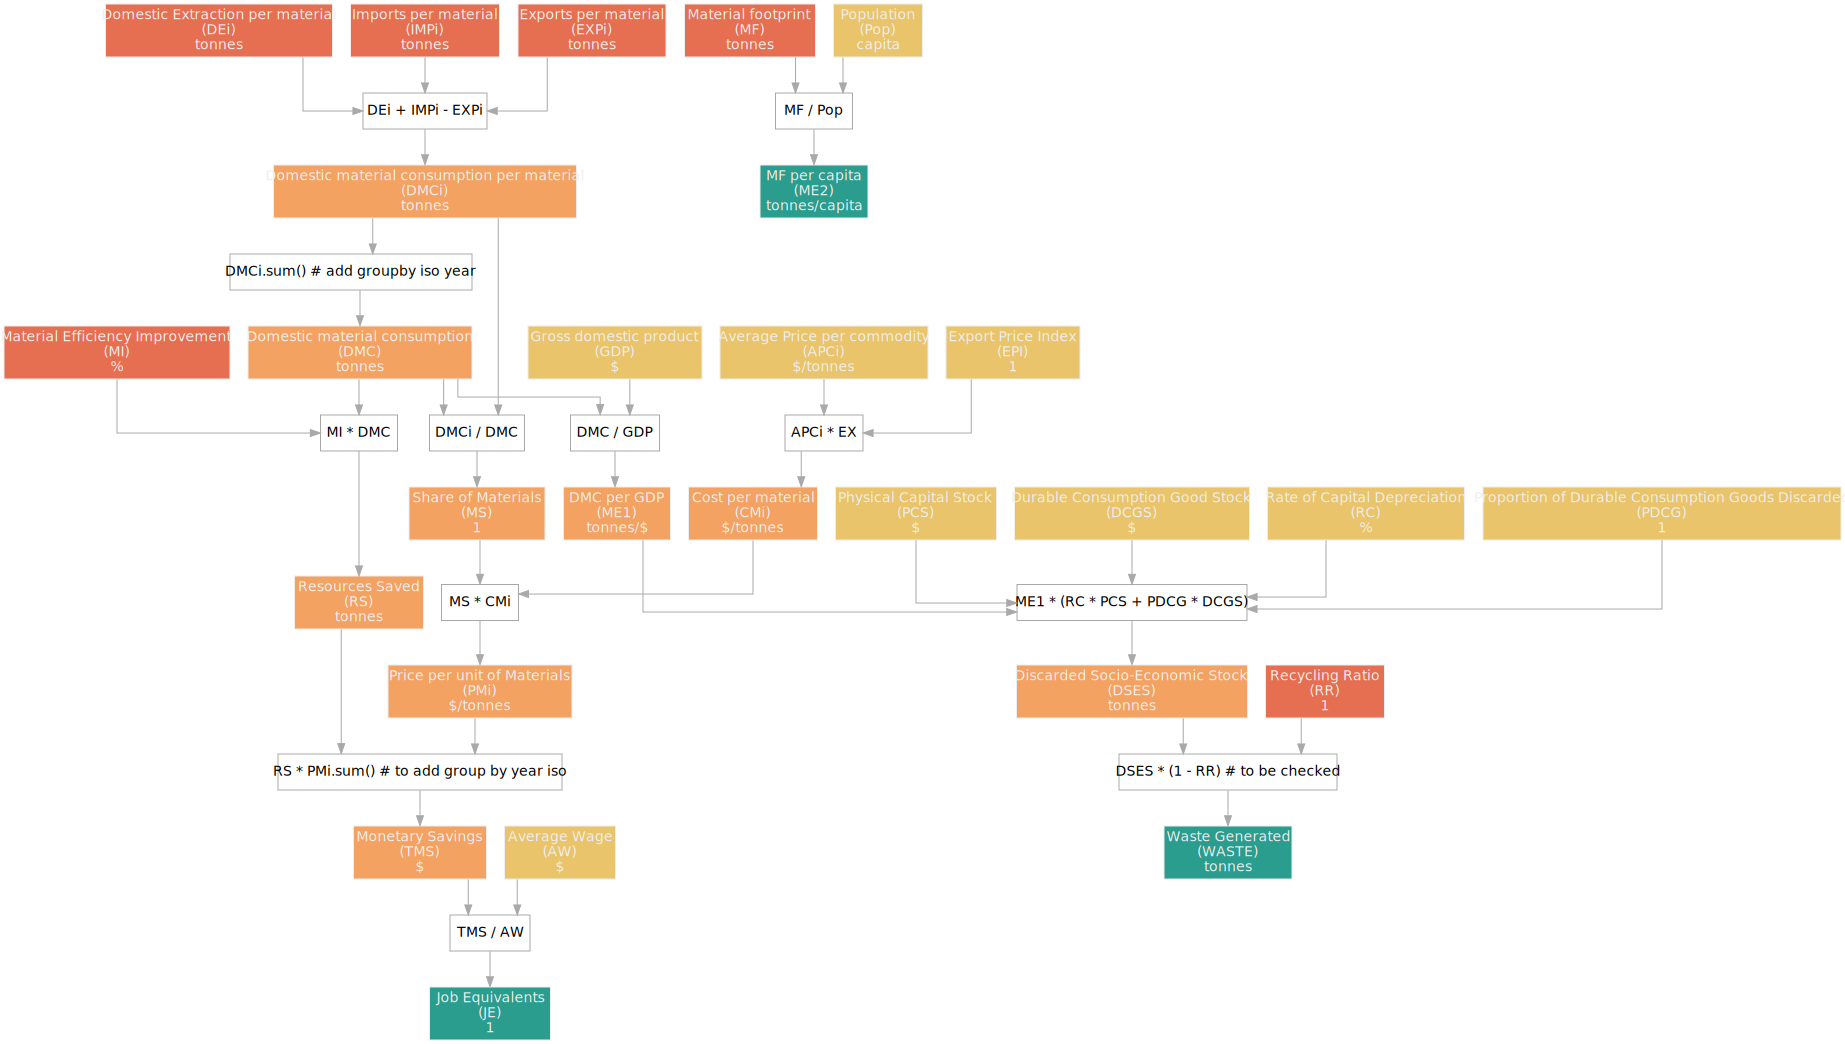

In [3]:
Waste_nodes = {'PCS': {'type': 'parameter',
                       'name': 'Physical Capital Stock',
                       'unit': '$'},
               'DCGS': {'type': 'parameter',
                        'name': 'Durable Consumption Good Stock',
                        'unit': '$'},
               'RC': {'type': 'parameter',
                      'name': 'Rate of Capital Depreciation',
                      'unit': '%'},
               'PDCG': {'type': 'parameter',
                        'name': 'Proportion of Durable Consumption Goods Discarded',
                        'unit': '1'},
               'DSES': {'type': 'variable',
                        'name': 'Discarded Socio-Economic Stock',
                        'unit': 'tonnes',
                        'computation': lambda ME1, RC, PCS, PDCG, DCGS, **kwargs: ME1 * (RC * PCS + PDCG * DCGS)
                        },
               'RR': {'type': 'input', 'name': 'Recycling Ratio', 'unit': '1'},
               'WASTE': {'type': 'output',
                         'name': 'Waste Generated',
                         'unit': 'tonnes',
                         'computation': lambda DSES, RR, **kwargs: DSES * (1 - RR) # to be checked
                         },
               'ME1': {'type': 'input', 'name': 'DMC per GDP', 'unit': 'tonnes/$'}}


VDMC_nodes = {'DEi': {'type': 'input',
                     'name': 'Domestic Extraction per material',
                     'unit': 'tonnes'},
              'IMPi': {'type': 'input', 'name': 'Imports per material', 'unit': 'tonnes'},
              'EXPi': {'type': 'input', 'name': 'Exports per material', 'unit': 'tonnes'},
              'DMCi': {'type': 'output',
                       'name': 'Domestic material consumption per material',
                       'unit': 'tonnes',
                       'computation': lambda DEi, IMPi, EXPi, **kwargs: DEi + IMPi - EXPi
                       }
              }

ME2_nodes = {'MF': {'type': 'input', 'name': 'Material footprint', 'unit': 'tonnes'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'ME2': {'type': 'output',
                     'name': 'MF per capita',
                     'unit': 'tonnes/capita',
                     'computation': lambda MF, Pop, **kwargs: MF / Pop
                     }
             }


ME1_nodes = {'DMC': {'type': 'input', 'name': 'Domestic material consumption', 'unit': 'tonnes'},
             'GDP': {'type': 'parameter', 'name': 'Gross domestic product', 'unit': '$'},
             'ME1': {'type': 'output',
                     'name': 'DMC per GDP',
                     'unit': 'tonnes/$',
                     'computation': lambda DMC, GDP, **kwargs: DMC / GDP
                    }
            }


JE_nodes = {'DMCi': {'type': 'variable', 'name': 'Domestic material consumption per material', 'unit': 'tonnes'},
            'DMC': {'type': 'variable',
                    'name': 'Domestic material consumption',
                    'unit': 'tonnes',
                    'computation': lambda DMCi, **kwargs: DMCi.sum() # add groupby iso year
                   },
            'MI': {'type': 'input',
                   'name': 'Material Efficiency Improvement',
                   'unit': '%'},
            'RS': {'type': 'variable',
                   'name': 'Resources Saved',
                   'unit': 'tonnes',
                   'computation': lambda MI, DMC, **kwargs: MI * DMC
                  },
            'MS': {'type': 'variable',
                   'name': 'Share of Materials',
                   'unit': '1',
                   'computation': lambda DMCi, DMC, **kwargs: DMCi / DMC
                  },
            'APCi': {'type': 'parameter',
                   'name': 'Average Price per commodity',
                   'unit': '$/tonnes'},
            'EPI': {'type': 'parameter',
                   'name': 'Export Price Index',
                   'unit': '1'},
            'CMi': {'type': 'variable',
                   'name': 'Cost per material',
                   'unit': '$/tonnes',
                   'computation': lambda APCi, EPI, **kwargs: APCi * EX
                  },
            'PMi': {'type': 'variable',
                   'name': 'Price per unit of Materials',
                   'unit': '$/tonnes',
                   'computation': lambda MS, CMi, **kwargs: MS * CMi
                  },
            'TMS': {'type': 'variable',
                    'name': 'Monetary Savings',
                    'unit': '$',
                    'computation': lambda PMi, RS, **kwargs: RS * PMi.sum() # to add group by year iso
                   },
            'AW': {'type': 'parameter', 'name': 'Average Wage', 'unit': '$'
                  },
            'JE': {'type': 'output',
                   'name': 'Job Equivalents',
                   'unit': '1',
                   'computation': lambda TMS, AW, **kwargs: TMS / AW
                  }
           }
GraphModel(concatenate_graph_specs([JE_nodes, ME1_nodes, ME2_nodes, VDMC_nodes, Waste_nodes])).draw()

# Info for database

# Tests

In [28]:
Waste_nodes = {'PCS': {'type': 'parameter',
                       'name': 'Physical Capital Stock',
                       'unit': '$'},
               'DCGS': {'type': 'parameter',
                        'name': 'Durable Consumption Good Stock',
                        'unit': '$'},
               'RC': {'type': 'parameter',
                      'name': 'Rate of Capital Depreciation',
                      'unit': '%'},
               'PDCG': {'type': 'parameter',
                        'name': 'Proportion of Durable Consumption Goods Discarded',
                        'unit': '1'},
               'DSES': {'type': 'variable',
                        'name': 'Discarded Socio-Economic Stock',
                        'unit': 'tonnes',
                        'computation': lambda ME1, RC, PCS, PDCG, DCGS, **kwargs: ME1 * (RC * PCS + PDCG * DCGS)
                        },
               'RR': {'type': 'input', 'name': 'Recycling Ratio', 'unit': '1'},
               'WASTE': {'type': 'output',
                         'name': 'Waste Generated',
                         'unit': 'tonnes',
                         'computation': lambda DSES, RR, **kwargs: DSES * (1 - RR) # to be checked
                         },
               'ME1': {'type': 'input', 'name': 'DMC per GDP', 'unit': 'tonnes/$'}}


VDMC_nodes = {'DEi': {'type': 'input',
                     'name': 'Domestic Extraction per material',
                     'unit': 'tonnes'},
              'IMPi': {'type': 'input', 'name': 'Imports per material', 'unit': 'tonnes'},
              'EXPi': {'type': 'input', 'name': 'Exports per material', 'unit': 'tonnes'},
              'DMCi': {'type': 'output',
                       'name': 'Domestic material consumption per material',
                       'unit': 'tonnes',
                       'computation': lambda DEi, IMPi, EXPi, **kwargs: DEi + IMPi - EXPi
                       }
              }


ME1_nodes = {'DMCi': {'type': 'variable', 'name': 'Domestic material consumption per material', 'unit': 'tonnes'},
            'DMC': {'type': 'variable',
                    'name': 'Domestic material consumption',
                    'unit': 'tonnes',
                    'computation': lambda DMCi, **kwargs: DMCi.sum() # add groupby iso year
                   },
             'GDP': {'type': 'parameter', 'name': 'Gross domestic product', 'unit': '$'},
             'ME1': {'type': 'output',
                     'name': 'DMC per GDP',
                     'unit': 'tonnes/$',
                     'computation': lambda DMC, GDP, **kwargs: DMC / GDP
                    }
            }


JE_nodes = {'DMCi': {'type': 'variable', 'name': 'Domestic material consumption per material', 'unit': 'tonnes'},
            'MI': {'type': 'input',
                   'name': 'Material Efficiency Improvement',
                   'unit': '%'},
            'APCi': {'type': 'parameter',
                   'name': 'Average Price per commodity',
                   'unit': '$/tonnes'},
            'EXWi': {'type': 'parameter',
                    'name': 'Export Weights',
                    'unit': '1'},
            'CMi': {'type': 'variable',
                   'name': 'Cost per material',
                   'unit': '$/tonnes',
                   'computation': lambda APCi, EXWi, **kwargs: APCi * EXWi
                  },
            'TMS': {'type': 'variable',
                    'name': 'Monetary Savings',
                    'unit': '$',
                    'computation': lambda MI, DMCi, CMi, **kwargs: MI * (DMCi * CMi).groupby(['ISO', 'Year']).sum()
                   },
            'AW': {'type': 'parameter', 'name': 'Average Wage', 'unit': '$'
                  },
            'JE': {'type': 'output',
                   'name': 'Job Equivalents',
                   'unit': '1',
                   'computation': lambda TMS, AW, **kwargs: TMS / AW
                  }
           }


model = GraphModel(concatenate_graph_specs([VDMC_nodes, JE_nodes]))

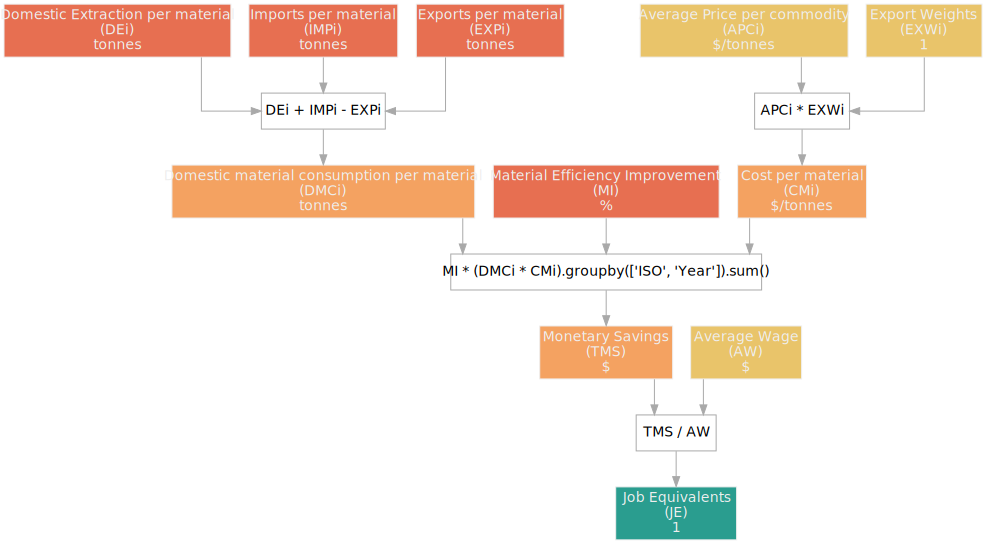

In [29]:
model.draw()

In [7]:
db_table_names = ['materialflow', 'imfindexcommodity', 'imfpricecommodity', 'pennworldtable', 'oecdwage', 'exportweight', 'worldbank']

data_dict = data_dict_from_db(db_table_names) 

data_dict['AW'] = data_dict['AW'].reset_index(level='Year').astype({'Year':str}).set_index('Year', append=True)['AW'] 

In [8]:
ISO_data_dict = {k: v.loc['HUN', :, :] for k, v in data_dict.items() if k not in ['APCi', 'EXWi', 'GDPC', 'GDP', 'Pop']}
ISO_data_dict['APCi'] = data_dict['APCi']
ISO_data_dict['MI'] = 1.5/100


ISO_data_dict['EXWi'] = data_dict['EXWi'].copy()
ISO_data_dict['EXWi'].loc['Biomass'] =.194
ISO_data_dict['EXWi'].loc['Metal ores'] = 0.114

ISO_data_dict['APCi'].loc['Biomass', '2017'] = 573
ISO_data_dict['APCi'].loc['Fossil fuels', '2017'] = 35.52
ISO_data_dict['APCi'].loc['Metal ores', '2017'] = 6150



In [9]:
X, y = get_X_y_from_data(model, ISO_data_dict)

In [10]:
res = model.run(X)

In [11]:
res['JE']

ISO  Year
HUN  1970             NaN
     1971             NaN
     1972             NaN
     1973             NaN
     1974             NaN
     1975             NaN
     1976             NaN
     1977             NaN
     1978             NaN
     1979             NaN
     1980             NaN
     1981             NaN
     1982             NaN
     1983             NaN
     1984             NaN
     1985             NaN
     1986             NaN
     1987             NaN
     1988             NaN
     1989             NaN
     1990             NaN
     1991             NaN
     1992             NaN
     1993             NaN
     1994             NaN
     1995             NaN
     1996             NaN
     1997             NaN
     1998             NaN
     1999             NaN
     2000             NaN
     2001             NaN
     2002             NaN
     2003             NaN
     2004             NaN
     2005             NaN
     2006             NaN
     2007             NaN
  

In [16]:
model = GraphModel(concatenate_graph_specs([ ME1_nodes, VDMC_nodes, Waste_nodes]))

In [19]:
data_dict.keys()

dict_keys(['DEi', 'DMCi', 'EXPi', 'IMPi', 'MFi', 'EPI', 'APCi', 'PCS', 'RC', 'AW', 'EXWi', 'AGVA', 'GDPC', 'IGVA', 'Pop', 'SGVA'])

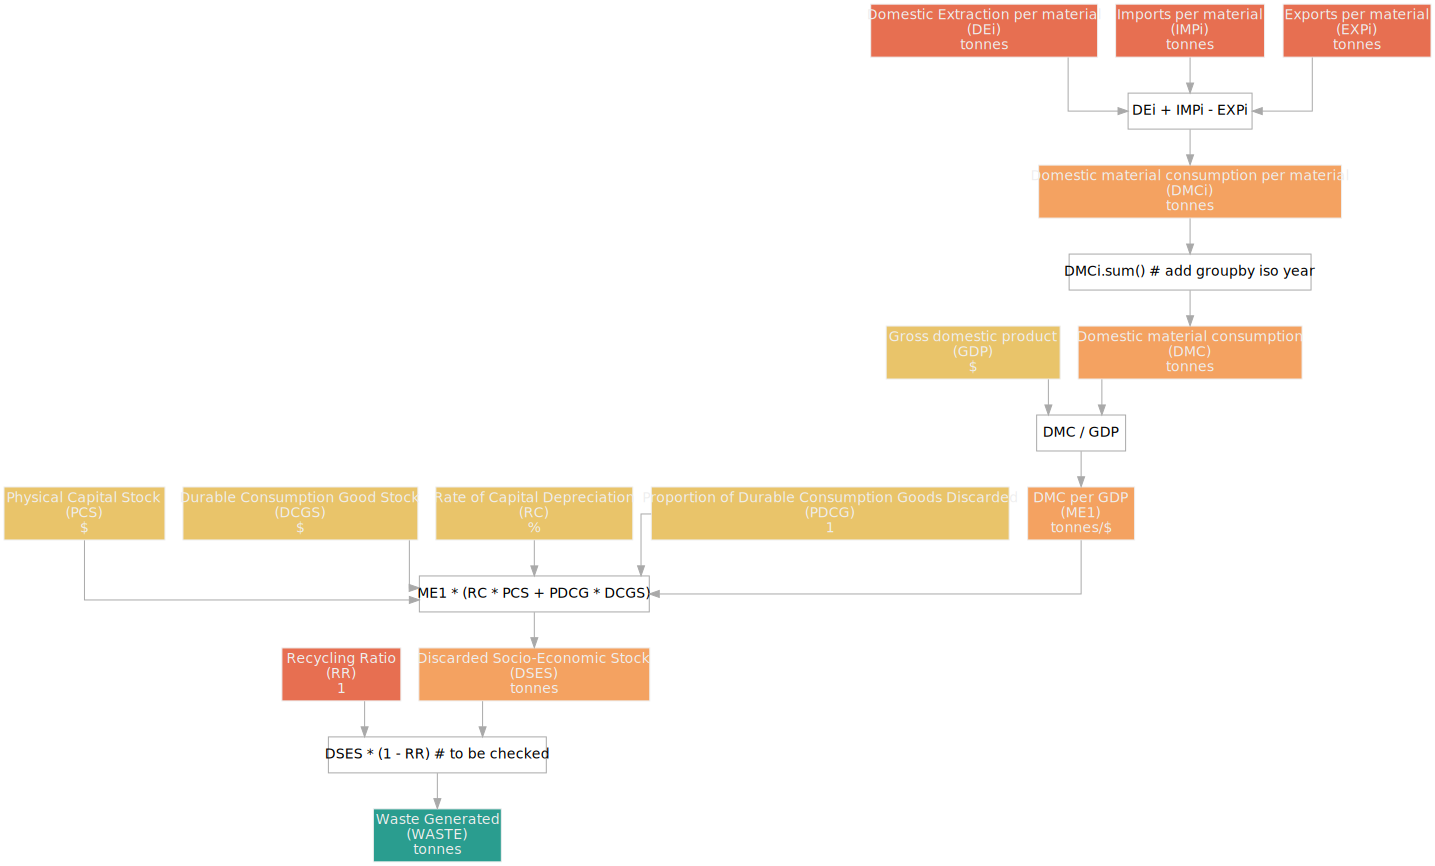

In [17]:
model.draw()

In [20]:
from data_utils.database import select_table

In [22]:
df = select_table('allvariables')

In [27]:
df[['Variable', 'table']].drop_duplicates().query('Variable in ["DCGS", "RC", "PDCG"]')

,Variable,table
994,RC,pennworldtable
